## MDS Plots
This notebook calculates the correlation matrix for the average models of the datasets and visualizes the relationships using Multi-Dimensional Scaling (MDS) plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import MDS
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.cio as cio
import PcmPy as pcm
import os
from collections import OrderedDict
import pandas as pd

In [2]:
def plot_MDS(dataset_list, mds_coords, title, dataset_vec_la=None, center=True, ax=None, plot_type="2D"):
    """
    Plots MDS coordinates in 2D or 3D.

    Parameters:
    - dataset_list: List of dataset names.
    - mds_coords: MDS coordinates (numpy array).
    - title: Title of the plot.
    - dataset_vec_la: Optional, dataset vector for grouping points.
    - center: Whether to center the axes.
    - ax: Matplotlib axis object (optional).
    - plot_type: "2D" or "3D" for the type of plot.
    """
    colors = plt.cm.tab10.colors

    if plot_type == "2D":
        if ax is None:
            ax = plt.gca()  # Get the current axis if none is provided
        if dataset_vec_la is None:
            for i, txt in enumerate(dataset_list):
                ax.scatter(mds_coords[i, 0], mds_coords[i, 1], color=colors[i % len(colors)], s=100)
                ax.annotate(txt, (mds_coords[i, 0], mds_coords[i, 1]), fontsize=10, textcoords="offset points", xytext=(0, 8), ha='center')
        else:
            for i, txt in enumerate(dataset_list):
                dataset_indices = [j for j, ds in enumerate(dataset_vec_la) if ds == txt]
                ax.scatter(mds_coords[dataset_indices, 0], mds_coords[dataset_indices, 1], 
                           color=colors[i % len(colors)], alpha=0.5, s=30, label=txt)
                ax.annotate(txt, (np.mean(mds_coords[dataset_indices, 0]), 
                                  np.mean(mds_coords[dataset_indices, 1])), 
                            fontsize=10, textcoords="offset points", xytext=(0, 8), ha='center')
        ax.set_title(title)
        ax.set_xlabel("MDS 1")
        ax.set_ylabel("MDS 2")
        if center:
            x_max = np.max(np.abs(mds_coords[:, 0])) * 1.2
            y_max = np.max(np.abs(mds_coords[:, 1])) * 1.2
            ax.set_xlim(-x_max, x_max)
            ax.set_ylim(-y_max, y_max)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
        plt.tight_layout()

    elif plot_type == "3D":
        if ax is None:
            ax = plt.figure().add_subplot(111, projection='3d')  # Create a new 3D axis if none is provided
        if dataset_vec_la is None:
            for i, txt in enumerate(dataset_list):
                ax.scatter(mds_coords[i, 0], mds_coords[i, 1], mds_coords[i, 2], color=colors[i % len(colors)], s=100)
                ax.text(mds_coords[i, 0], mds_coords[i, 1], mds_coords[i, 2], txt, fontsize=10, ha='center')
        else:
            for i, txt in enumerate(dataset_list):
                dataset_indices = [j for j, ds in enumerate(dataset_vec_la) if ds == txt]
                ax.scatter(mds_coords[dataset_indices, 0], mds_coords[dataset_indices, 1], mds_coords[dataset_indices, 2], 
                           color=colors[i % len(colors)], alpha=0.5, s=30, label=txt)
        ax.set_title(title)
        ax.set_xlabel("MDS 1")
        ax.set_ylabel("MDS 2")
        ax.set_zlabel("MDS 3")
        ax.legend(loc='upper left', fontsize=8)

In [3]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
train_ses = ["all", "ses-localizer_cond", "all", "all", "all", "all", "all"]
cerebellum = "MNISymC3"

In [4]:
coef_list = {}
method_list = ["L2reg", "L2reghalf"]
logalpha_1 = [8, 8, 8, 8, 8, 10, 8]
logalpha_2 = [6, 6, 6, 2, 2, 8, 6]
logalpha_list = [logalpha_1, logalpha_2]

# Load L2reg, L2reghalf avg models of datasets to check similarity
for method, la_list in zip(method_list, logalpha_list):
    coef_list[method] = []
    for i, (la, tdata, tses) in enumerate(zip(la_list, dataset_list, train_ses)):
        print(f'Loading avg model for {tdata} - {tses}')
        mname = f"{tdata}_{tses}_Icosahedron1002_{method}"
        model_path = os.path.join(gl.conn_dir,cerebellum,'train',mname)
        m = mname + f"_A{la}_avg"
        fname = model_path + f"/{m}"
        conn_mo, info = cio.load_model(fname)
        coef_list[method].append(conn_mo.coef_)

Loading avg model for MDTB - all
Loading avg model for Language - ses-localizer_cond
Loading avg model for WMFS - all
Loading avg model for Demand - all
Loading avg model for Somatotopic - all
Loading avg model for Nishimoto - all
Loading avg model for IBC - all
Loading avg model for MDTB - all
Loading avg model for Language - ses-localizer_cond
Loading avg model for WMFS - all
Loading avg model for Demand - all
Loading avg model for Somatotopic - all
Loading avg model for Nishimoto - all
Loading avg model for IBC - all


In [ ]:
# Calculate the correlation matrix
corr_matrix = {}
for method in method_list:
    corr_matrix[method] = np.zeros((len(dataset_list), len(dataset_list)))
    for i in range(len(dataset_list)):
        for j in range(i, len(dataset_list)):
            a = coef_list[method][i].flatten()
            b = coef_list[method][j].flatten()
            corr_matrix[method][i, j] = np.corrcoef(a, b)[0, 1]
            corr_matrix[method][j, i] = corr_matrix[method][i, j]

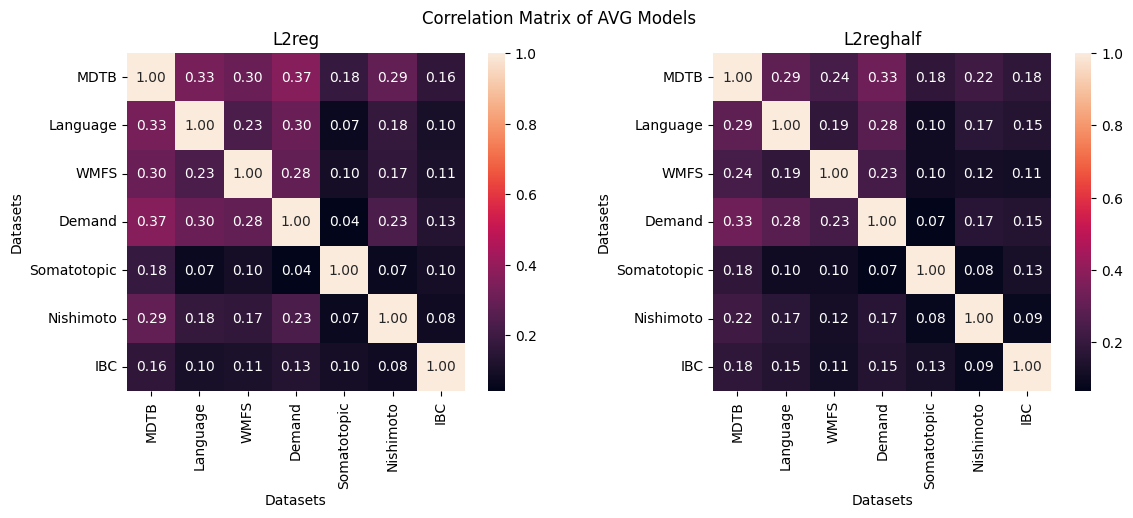

In [13]:
# Plot the correlation matrix
plt.subplots(1,2, figsize=(12, 5))
plt.suptitle("Correlation Matrix of AVG Models")

for i, method in enumerate(method_list):
    plt.subplot(1, 2, i+1)
    sns.heatmap(corr_matrix[method], annot=True, fmt=".2f", xticklabels=dataset_list, yticklabels=dataset_list, square=True)
    plt.title(method)
    plt.xlabel("Datasets")
    plt.ylabel("Datasets")
plt.tight_layout()

MDS stress (metric=True): 0.90
MDS stress (metric=False): 0.09


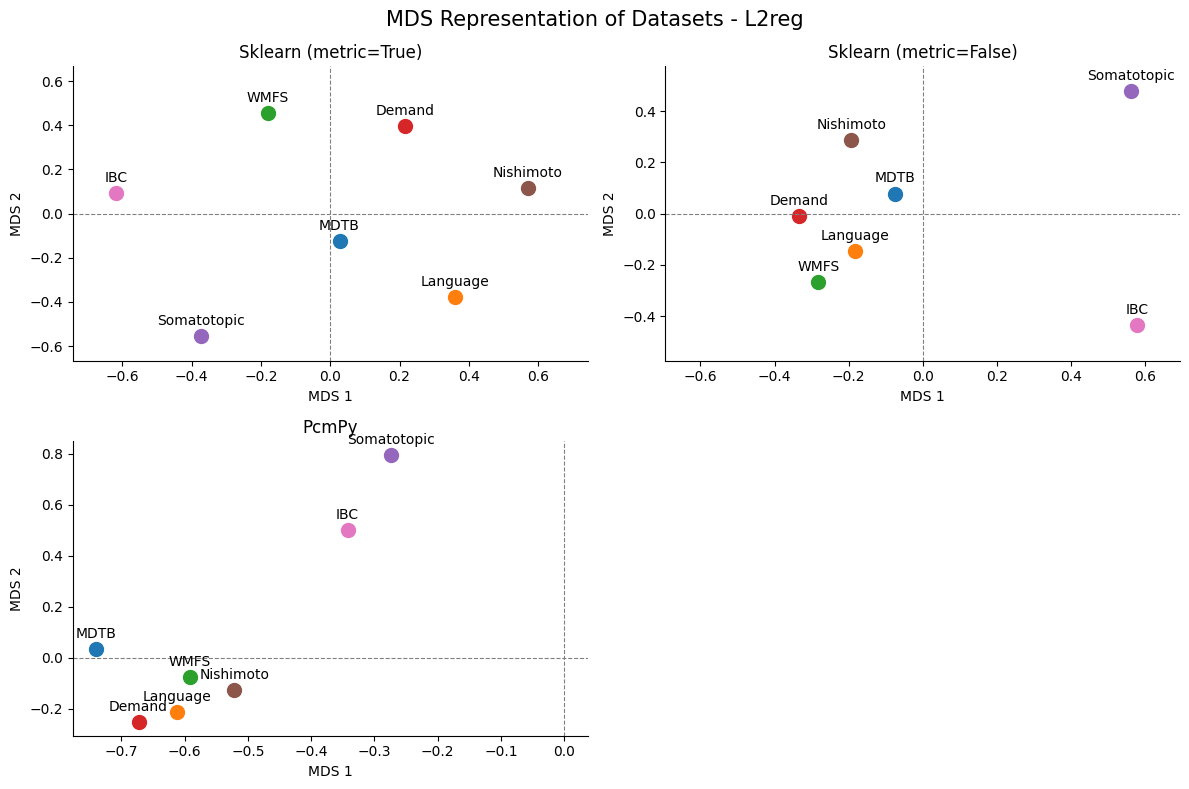

MDS stress (metric=True): 1.01
MDS stress (metric=False): 0.09


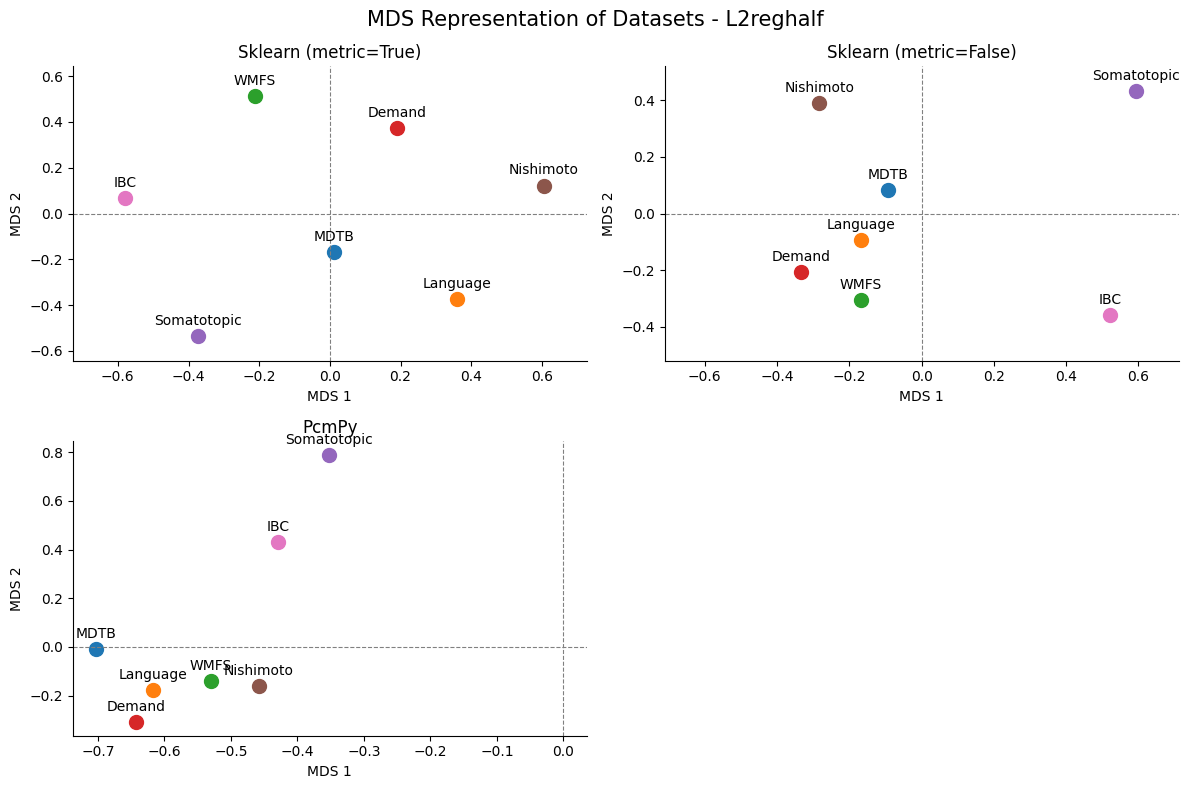

In [7]:
plot_type = "2D"

for method in method_list:
    if plot_type == "2D":
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        n_components = 2
    elif plot_type == "3D":
        fig = plt.figure(figsize=(12, 8))
        axes = [fig.add_subplot(2, 2, i+1, projection='3d') for i in range(4)]
        n_components = 3
    plt.suptitle(f"MDS Representation of Datasets - {method}", fontsize=15)

    # Subplot 1 - Metric MDS
    mds = MDS(n_components=n_components, dissimilarity="precomputed", random_state=42, metric=True, normalized_stress=False)
    mds_coords = mds.fit_transform(1 - corr_matrix[method])
    print(f'MDS stress (metric=True): {mds.stress_:.2f}')
    plot_MDS(dataset_list, mds_coords, "Sklearn (metric=True)", ax=axes[0], plot_type=plot_type)

    # Subplot 2 - Non-metric MDS
    mds = MDS(n_components=n_components, dissimilarity="precomputed", random_state=42, metric=False, normalized_stress=True)
    mds_coords = mds.fit_transform(1 - corr_matrix[method])
    print(f'MDS stress (metric=False): {mds.stress_:.2f}')
    plot_MDS(dataset_list, mds_coords, "Sklearn (metric=False)", ax=axes[1], plot_type=plot_type)

    # Subplot 3 - PcmPy Classical MDS
    W, _ = pcm.util.classical_mds(corr_matrix[method])
    plot_MDS(dataset_list, W, "PcmPy", center=False, ax=axes[2], plot_type=plot_type)

    # Delete 4th subplot (bottom-right)
    fig.delaxes(axes[3])

    plt.tight_layout()
    plt.show()

    # Save the figure
    # fig.savefig(f'/home/UWO/ashahb7/tsclient/Horizon Server/MDS_Representation_{method}.png', dpi=300)

### Covariance Matrix Plot

This section visualizes the covariance matrix for all subjects, all datasets, all logalphas, and all partitions. The covariance matrix shows relationships and similarities.

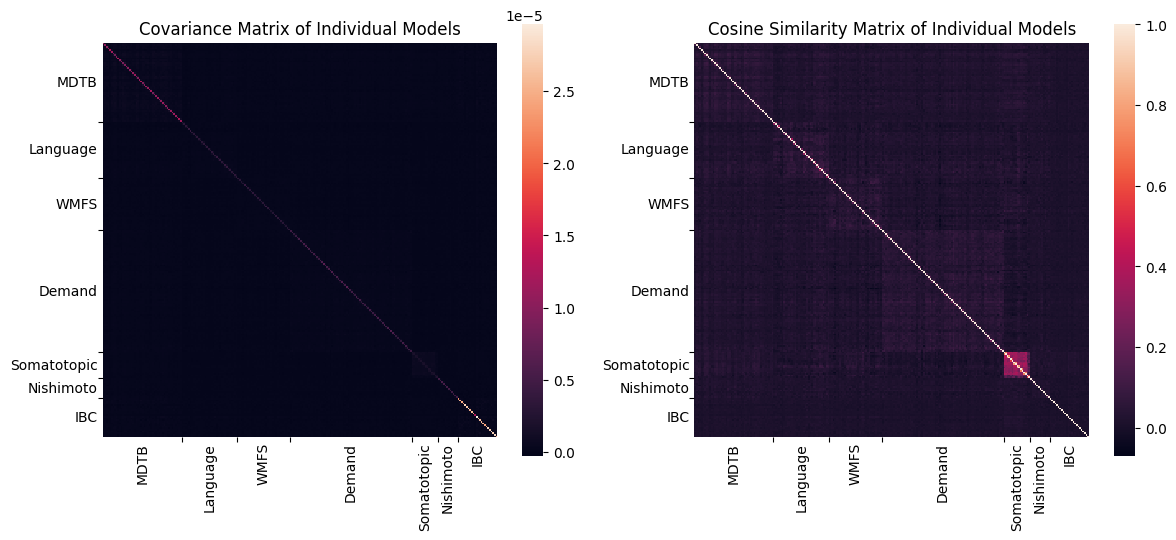

In [15]:
# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/bestSTD_product_matrix.npz", allow_pickle=True)
# select subset of covariance matrix
indices = []
for ds, la in zip(dataset_list, logalpha_list[1]):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
covariance_la = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec_la = data['dataset_vec'][indices]
sub_vec_la = data['sub_vec'][indices]
part_vec_la = data['part_vec'][indices]

# Calculate the norm of each original vector to convert covariance matrix to correlation matrix
norm_vec = np.zeros(len(dataset_vec_la))
norm_vec = np.sqrt(np.diag(covariance_la))# * (1876 * 5446))
corr_la = covariance_la / np.outer(norm_vec, norm_vec)

plt.subplots(1,2, figsize=(14, 7))
for d, data in enumerate([covariance_la, corr_la]):
    data_to_plot = data.copy()

    # Set diagonal elements to 0
    # np.fill_diagonal(data_to_plot, 0)
    # for i in range(data_to_plot.shape[0]):
    #     if i > 0:
    #         data_to_plot[i, i - 1] = 0
    #     if i < data_to_plot.shape[0] - 1:
    #         data_to_plot[i, i + 1] = 0

    plt.subplot(1, 2, d+1)
    sns.heatmap(data_to_plot, square=True, cbar_kws={'shrink': 0.8})

    # Remove numbers on x and y ticks
    plt.xticks([])
    plt.yticks([])
    if d == 0:
        plt.title("Covariance Matrix of Individual Models")
    else:
        plt.title("Cosine Similarity Matrix of Individual Models")

    # Add block labels for datasets
    unique_datasets = list(OrderedDict.fromkeys(dataset_vec_la))
    dataset_start_indices = [np.where(dataset_vec_la == ds)[0][0] for ds in unique_datasets]

    for i, start_idx in enumerate(dataset_start_indices):
        end_idx = dataset_start_indices[i + 1] if i + 1 < len(dataset_start_indices) else len(dataset_vec_la)
        mid_idx = (start_idx + end_idx) // 2
        plt.text(mid_idx, len(dataset_vec_la)+3, unique_datasets[i], ha='center', va='top', fontsize=10, rotation=90, color='black')
        plt.text(-3, mid_idx, unique_datasets[i], ha='right', va='center', fontsize=10, color='black')

    # Add ticks in the x-axis and y-axis for dataset blocks without labels
    plt.xticks(dataset_start_indices[1:], [])
    plt.yticks(dataset_start_indices[1:], [])

MDS stress (metric=True): 2905.88
MDS stress (metric=False): 0.24


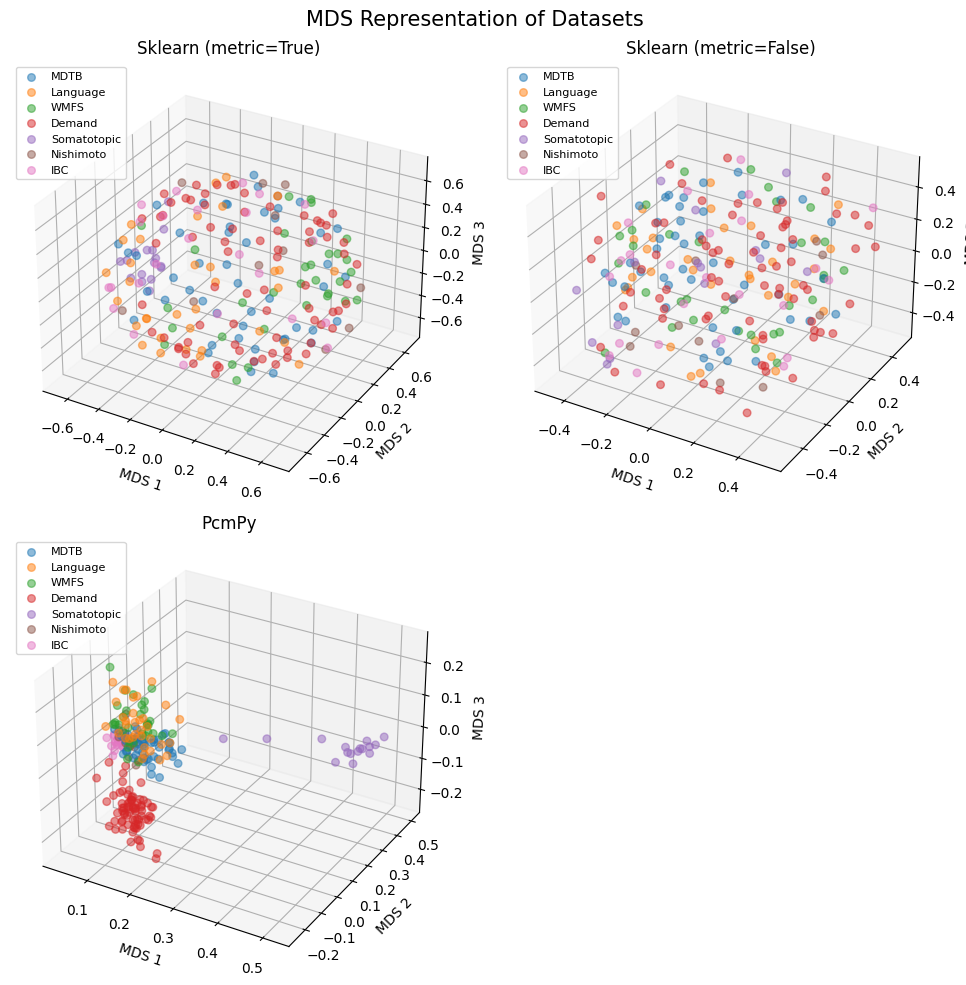

In [9]:
fig = plt.figure(figsize=(10, 10))
axes = [fig.add_subplot(2, 2, i+1, projection='3d') for i in range(4)]
plt.suptitle("MDS Representation of Datasets", fontsize=15)

# Subplot 1 - Metric MDS
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42, metric=True, normalized_stress=False)
mds_coords = mds.fit_transform(1-corr_la)
print(f'MDS stress (metric=True): {mds.stress_:.2f}')
plot_MDS(dataset_list, mds_coords, "Sklearn (metric=True)", dataset_vec_la=dataset_vec_la, ax=axes[0], plot_type="3D")

# Subplot 2 - Non-metric MDS
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42, metric=False, normalized_stress=True)
mds_coords = mds.fit_transform(1-corr_la)
print(f'MDS stress (metric=False): {mds.stress_:.2f}')
plot_MDS(dataset_list, mds_coords, "Sklearn (metric=False)", dataset_vec_la=dataset_vec_la, ax=axes[1], plot_type="3D")

# Subplot 3 - PcmPy Classical MDS
W, _ = pcm.util.classical_mds(corr_la)
plot_MDS(dataset_list, W, "PcmPy", dataset_vec_la=dataset_vec_la, center=False, ax=axes[2], plot_type="3D")

# Delete 4th subplot (bottom-right)
fig.delaxes(axes[3])

plt.tight_layout()
plt.show()

# Save the figure
# fig.savefig('/home/UWO/ashahb7/tsclient/Horizon Server/MDS_Representation.png', dpi=300)